In [33]:
# # GitHub Repository Setup
#
# This cell navigates to `/content`, removes any previous clone of the repository,
# clones the latest version from GitHub, and lists the repository files.

# %%
%cd /content
!rm -rf Gradu
!git clone https://github.com/Elkkujou/Gradu.git
%cd /content/Gradu
!ls


/content
Cloning into 'Gradu'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 90 (delta 42), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 5.24 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/Gradu
 chatti_RF.ipynb	       FT_source.xlsx  'RF REGIIMI HYVÄ TRAINING.ipynb'   THE_ONE.xlsx
'Financial turbulence.ipynb'   RF_Gradu.ipynb  'RF_regime (3).ipynb'


In [34]:
skip_training = False

In [35]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate


In [36]:
# # Load Excel Data & Define Global Constants
#
# Read the Excel file, parse the desired sheet, flatten any multi-index columns,
# and define global constants that will be used throughout the notebook.

# %%
# Load and flatten the data
xls_file = pd.ExcelFile("/content/Gradu/THE_ONE.xlsx")
df = xls_file.parse("returns non-log")
df.columns = df.columns.get_level_values(0)

# Global constants for columns (change names to uppercase for constants)
VALID_FACTORS = [
    'USA MOMENTUM Standard (Large+Mid Cap)',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)'
]
FEATURES = ['VIXCLS', 'CPI', 'LEI', '10yr', 'Financial Turbulance', 'Regimes']
REGIMES_COLUMN = 'Regimes'


In [37]:
# # Prepare Data for Model Training
#
# Filter the dataset to include only rows with valid factors,
# encode categorical columns, drop missing values, and sort by date.

# %%
# Filter rows based on the global VALID_FACTORS
df = df[df['Winning Factor'].isin(VALID_FACTORS)].reset_index(drop=True)

# Encode the Regimes column using the global constant
df[REGIMES_COLUMN] = df[REGIMES_COLUMN].astype('category').cat.codes

# Define features and target using the global FEATURES constant
X = df[FEATURES].dropna()
y = df['Winning Factor'].astype('category').cat.codes.loc[X.index]

print("Indices aligned:", X.index.equals(y.index))

# Ensure the data is sorted by date
df = df.sort_values('Date').reset_index(drop=True)

# Verify required columns exist
required_columns = FEATURES + ['USA Standard (Large+Mid Cap)'] + VALID_FACTORS
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")
print("Parameters and dataset verified.")


Indices aligned: True
Parameters and dataset verified.


In [38]:
# # Encode Winning Factor & Build Mappings
#
# Pre-encode the 'Winning Factor' column and create dictionaries to map full factor names
# to shorter names and numeric IDs for later reference.

# %%
df['Winning Factor Encoded'] = df['Winning Factor'].astype('category').cat.codes
winning_factor_categories = df['Winning Factor'].astype('category').cat.categories
winning_factor_mapping = {i: cat for i, cat in enumerate(winning_factor_categories)}

factor_rename_mapping = {
    'USA MOMENTUM Standard (Large+Mid Cap)': 'Momentum',
    'USA MINIMUM VOLATILITY (USD) Standard (Large+Mid Cap)': 'MinVol',
    'USA RISK WEIGHTED Standard (Large+Mid Cap)': 'RiskWeighted',
    'USA SECTOR NEUTRAL QUALITY Standard (Large+Mid Cap)': 'SectorNeutral',
    'USA ENHANCED VALUE Standard (Large+Mid Cap)': 'EnhancedValue'
}

winning_factor_dict = {
    full_factor: {
        'full': full_factor,
        'short': factor_rename_mapping.get(full_factor, full_factor),
        'id': i
    } for i, full_factor in enumerate(winning_factor_categories)
}


In [39]:
# # Define Rolling Window Parameters
#
# Set the training percentage, window size, and step size for the rolling window model training.

# %%
train_pct = 1.00  # Use 100% of data for rolling window training
train_end_idx = int(len(df) * train_pct)

window_size = 120   # Number of observations per training window
step_size = 1      # Step size for rolling window


### Random Forest Hyperparameters Table

| Hyperparameter       | Purpose                                   | Common Choices                  |
|----------------------|-------------------------------------------|---------------------------------|
| `n_estimators`      | Number of trees                           | 100 (default), 200, 500         |
| `max_depth`         | Max tree depth                            | `None` (default), 10, 20        |
| `min_samples_split` | Min samples needed to split a node       | 2 (default), 10, 20             |
| `min_samples_leaf`  | Min samples in a leaf                    | 1 (default), 5, 10              |
| `max_features`      | Features per split                       | `'sqrt'` (default), `'log2'`, `None` |
| `bootstrap`         | Use bootstrap sampling                    | `True` (default), `False`       |
| `random_state`      | Set a random seed                         | `None`, 42, 0                   |
| `criterion`         | Splitting method                          | `'gini'` (default), `'entropy'` |
| `oob_score`        | Out-of-bag validation                     | `False` (default), `True`       |
| `n_jobs`           | Parallel training                         | `None`, `-1` (all CPUs)         |


In [40]:
# # Rolling Window Training & Prediction
#
# Train a Random Forest model in a rolling window fashion. For each window, split the data,
# train the model, predict probabilities, and record detailed results including feature importances.

# %%
allocated_returns = []
all_true_labels = []
all_pred_labels = []
detailed_results = []

feature_importances_list = []
probability_matrix = []  # To record predicted probability vectors
probability_dates = []   # Corresponding dates for each prediction

# Loop through the data using a rolling window
for start_idx in range(0, train_end_idx - window_size, step_size):
    train_idx = range(start_idx, start_idx + window_size)
    test_idx = [start_idx + window_size]

    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]

    X_train = train_data[FEATURES].dropna()
    y_train = train_data['Winning Factor Encoded'].loc[X_train.index]
    X_test = test_data[FEATURES].dropna()

    X_train, y_train = X_train.align(y_train, axis=0)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    feature_importances_list.append(rf_model.feature_importances_)

    if not X_test.empty:
        probabilities = rf_model.predict_proba(X_test)
        probability_matrix.append(probabilities[0])
        probability_dates.append(test_data['Date'].values[0])

        # Use the global VALID_FACTORS for portfolio return calculation
        portfolio_return = (probabilities * test_data[VALID_FACTORS].values).sum(axis=1)
        allocated_returns.extend(portfolio_return)

        y_pred = probabilities.argmax(axis=1)[0]
        y_test = test_data['Winning Factor Encoded'].iloc[0]
        all_true_labels.append(y_test)
        all_pred_labels.append(y_pred)

        full_pred = winning_factor_mapping[y_pred]
        full_test = winning_factor_mapping[y_test]
        result_dict = {
            'Date': test_data['Date'].values[0],
            'Correct': (y_pred == y_test),
            'Predicted_Winner': winning_factor_dict[full_pred]['short'],
            'Actual_Winner': winning_factor_dict[full_test]['short'],
            'Allocated_Return': portfolio_return[0],
            'Max_Probability': probabilities[0, y_pred]
        }
        for i, full_factor in enumerate(winning_factor_categories):
            short_name = winning_factor_dict[full_factor]['short']
            result_dict[f'Prob_{short_name}'] = probabilities[0, i]
        detailed_results.append(result_dict)


In [52]:
from IPython.display import display, HTML

display(HTML(
    f"<br><div style='font-size:24px; text-align:center; margin:20px 0;'>"
    f"Rolling Window Out-of-Sample Accuracy: {accuracy:.2%}"
    f"</div><br>"
))


In [54]:
#LAITA VAAN esim. 10000 niin kaikki näkyy

num_rows_to_show = 10

# Create and print a table summarizing the prediction results from the rolling window,
# including dates, correctness, predictions, and allocated returns.
# You can control how many rows are displayed by setting the variable `num_rows_to_show`.

# %%
detailed_results_df = pd.DataFrame(detailed_results)
prob_cols = [col for col in detailed_results_df.columns if col.startswith('Prob_')]
ordered_cols = ['Date', 'Correct', 'Predicted_Winner', 'Actual_Winner'] + prob_cols + ['Allocated_Return', 'Max_Probability']
detailed_results_df = detailed_results_df[ordered_cols]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set the number of rows to display. Change 1000 to the desired number.


print(tabulate(detailed_results_df.head(num_rows_to_show), headers='keys', tablefmt='psql', showindex=False))


+---------------------+-----------+--------------------+-----------------+----------------------+---------------+-----------------+---------------------+----------------------+--------------------+-------------------+
| Date                | Correct   | Predicted_Winner   | Actual_Winner   |   Prob_EnhancedValue |   Prob_MinVol |   Prob_Momentum |   Prob_RiskWeighted |   Prob_SectorNeutral |   Allocated_Return |   Max_Probability |
|---------------------+-----------+--------------------+-----------------+----------------------+---------------+-----------------+---------------------+----------------------+--------------------+-------------------|
| 2000-03-31 00:00:00 | False     | Momentum           | EnhancedValue   |                 0.23 |          0.04 |            0.48 |                0.04 |                 0.21 |         0.0897005  |              0.48 |
| 2000-04-28 00:00:00 | False     | SectorNeutral      | RiskWeighted    |                 0.24 |          0.07 |            0.2

Rolling Window Out-of-Sample Accuracy: 32.63%


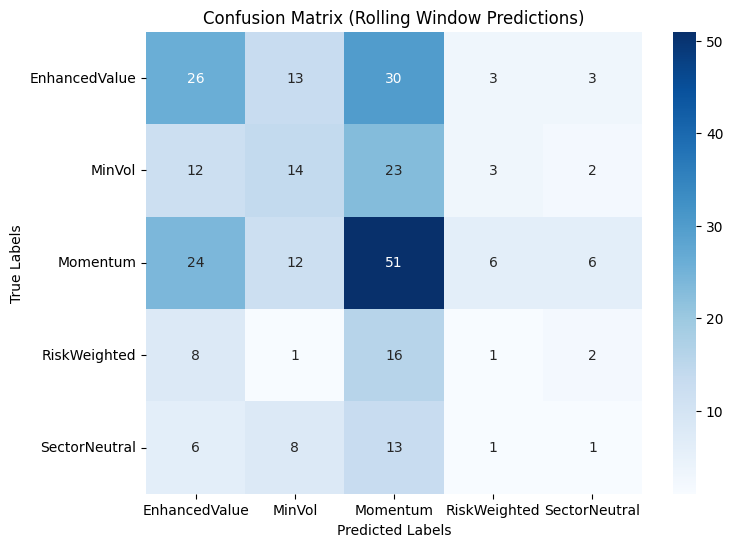

In [42]:
# # Evaluate Accuracy & Confusion Matrix
#
# Compute the overall prediction accuracy and display a confusion matrix heatmap.

# %%
accuracy = accuracy_score(all_true_labels, all_pred_labels)
print(f"Rolling Window Out-of-Sample Accuracy: {accuracy:.2%}")

# Use REGIMES_COLUMN for consistency if needed; here, we build labels based on winning factors.
labels = [winning_factor_dict[winning_factor_mapping[i]]['short'] for i in sorted(winning_factor_mapping.keys())]
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Rolling Window Predictions)")
plt.show()


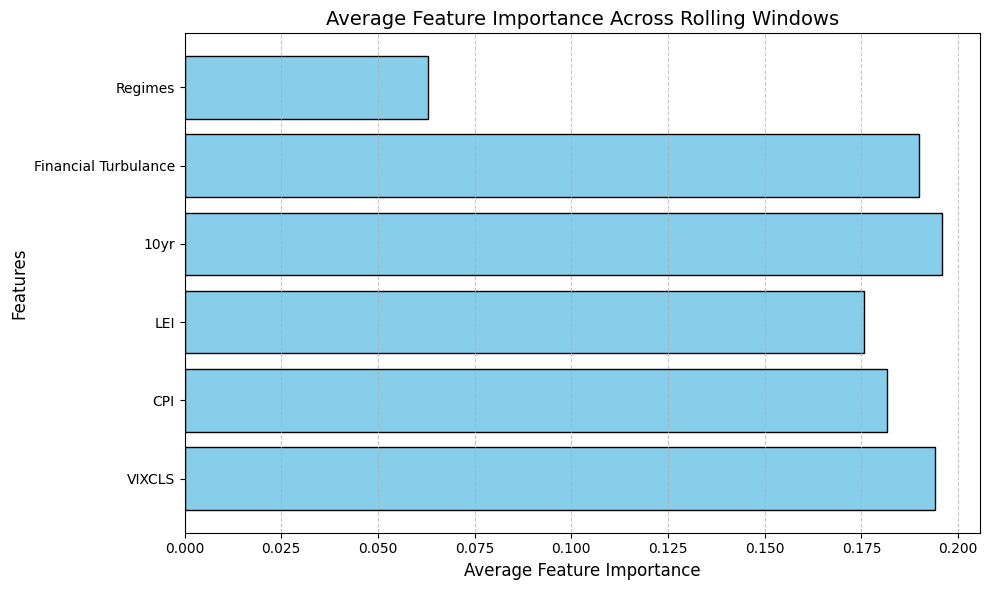

In [43]:
# # Plot Average Feature Importances
#
# Calculate and visualize the average feature importances across all rolling windows using a horizontal bar chart.

# %%
feature_importances_array = np.array(feature_importances_list)
average_feature_importance = feature_importances_array.mean(axis=0)

feature_names = FEATURES  # Use the global FEATURES constant

plt.figure(figsize=(10, 6))
plt.barh(feature_names, average_feature_importance, color='skyblue', edgecolor='black')
plt.xlabel("Average Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Average Feature Importance Across Rolling Windows", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


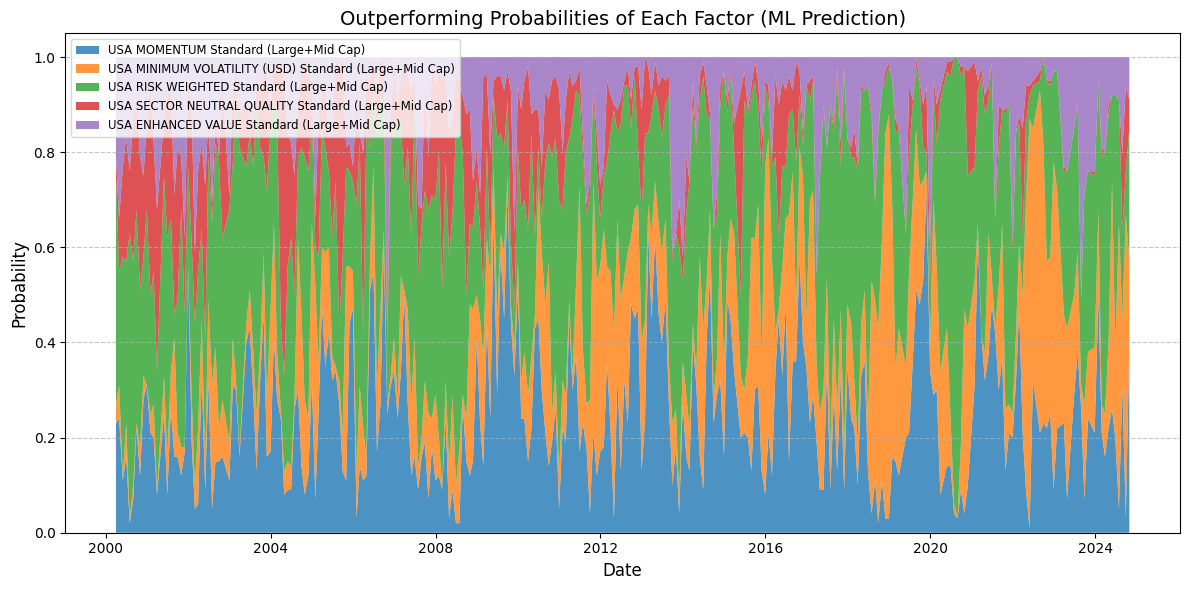

In [44]:
# # Plot Stacked Area Chart of Probabilities
#
# Visualize the evolution of predicted probabilities for each factor over time using a stacked area chart.

# %%
# Build a DataFrame from the probability matrix using the global VALID_FACTORS
probability_df = pd.DataFrame(probability_matrix, columns=VALID_FACTORS)
probability_df['Date'] = probability_dates
probability_df = probability_df.sort_values("Date").reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.stackplot(
    probability_df['Date'],
    [probability_df[col] for col in VALID_FACTORS],
    labels=VALID_FACTORS,
    alpha=0.8
)
plt.title("Outperforming Probabilities of Each Factor (ML Prediction)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.legend(loc='upper left', fontsize='small')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


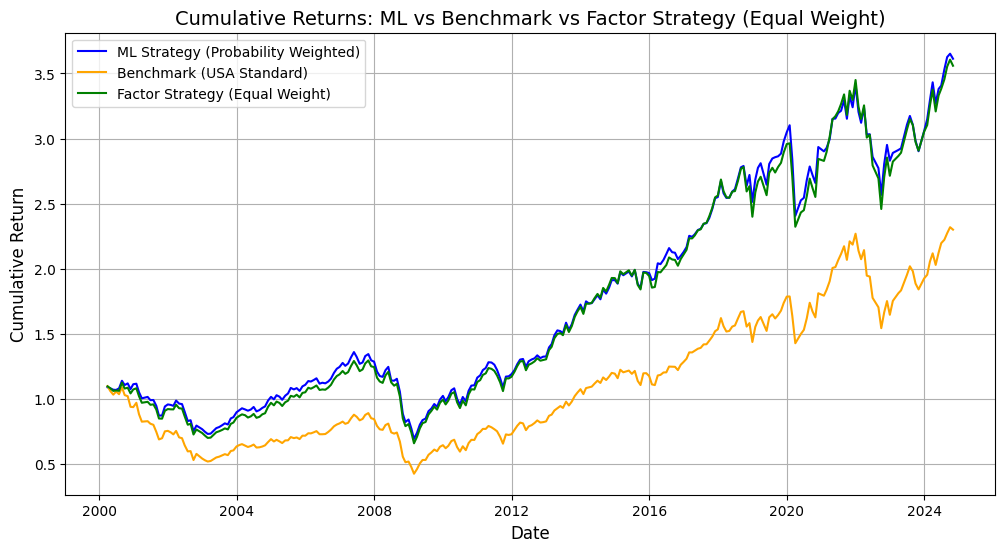

In [45]:

# This cell also ensures that the time axis is aligned for all three strategies.

# Extract ML strategy and benchmark returns (as before)
strategy_returns = np.array(allocated_returns)
benchmark_returns = df.iloc[window_size:]['USA Standard (Large+Mid Cap)'].values[:len(strategy_returns)]

# Compute cumulative returns for ML strategy and benchmark
cumulative_strategy = (1 + strategy_returns).cumprod()
cumulative_benchmark = (1 + benchmark_returns).cumprod()

# Compute the equal-weight factor strategy returns:
# For each date (from window_size onward), take the average of the factor returns.
# Ensure that we use the same number of observations as ML strategy returns.
factor_equal_returns = df.iloc[window_size:][VALID_FACTORS].mean(axis=1).values[:len(strategy_returns)]
cumulative_factor_equal = (1 + factor_equal_returns).cumprod()

# Plot all three cumulative return series
plt.figure(figsize=(12, 6))
dates = df.loc[window_size:, 'Date'][:len(cumulative_strategy)]  # common date series

plt.plot(dates, cumulative_strategy, label="ML Strategy (Probability Weighted)", color="blue")
plt.plot(dates, cumulative_benchmark, label="Benchmark (USA Standard)", color="orange")
plt.plot(dates, cumulative_factor_equal, label="Factor Strategy (Equal Weight)", color="green")

plt.title("Cumulative Returns: ML vs Benchmark vs Factor Strategy (Equal Weight)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend()
plt.grid()
plt.show()


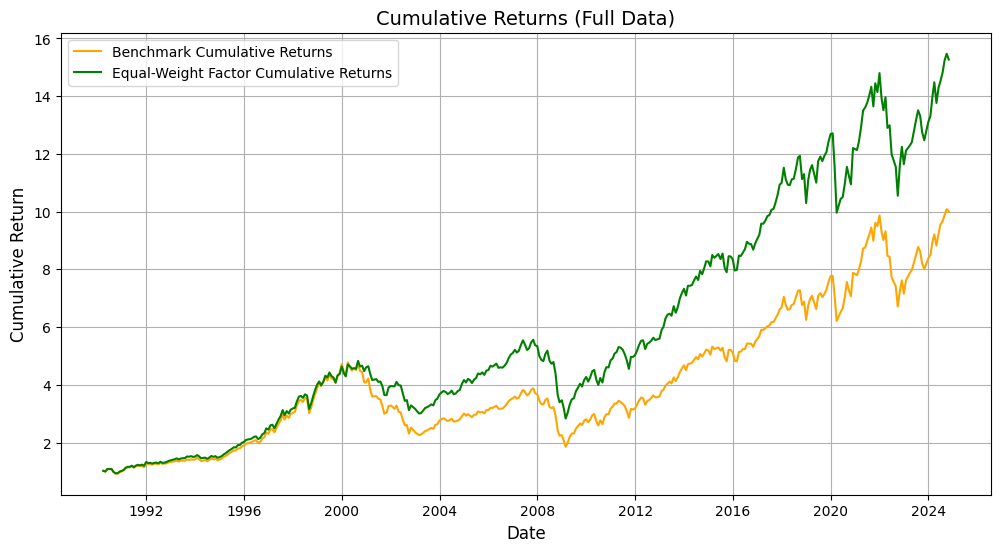

Annualized Return (Benchmark): 7.06%
Annualized Return (Equal-Weight Factor Strategy): 8.41%



In [46]:
# --- Plotting the cumulative returns chart ---
# Extract full-time returns
benchmark_returns_all = df['USA Standard (Large+Mid Cap)']
cumulative_benchmark_all = (1 + benchmark_returns_all).cumprod()

factor_equal_returns_all = df[VALID_FACTORS].mean(axis=1)
cumulative_factor_equal_all = (1 + factor_equal_returns_all).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], cumulative_benchmark_all, label="Benchmark Cumulative Returns", color="orange")
plt.plot(df['Date'], cumulative_factor_equal_all, label="Equal-Weight Factor Cumulative Returns", color="green")
plt.title("Cumulative Returns (Full Data)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend()
plt.grid()
plt.show()

# --- Calculate and print annualized returns ---
n_benchmark = len(benchmark_returns_all)
n_factor = len(factor_equal_returns_all)

annualized_return_benchmark = cumulative_benchmark_all.iloc[-1]**(12 / n_benchmark) - 1
annualized_return_factor = cumulative_factor_equal_all.iloc[-1]**(12 / n_factor) - 1

print(f"Annualized Return (Benchmark): {annualized_return_benchmark:.2%}")
print(f"Annualized Return (Equal-Weight Factor Strategy): {annualized_return_factor:.2%}\n")




In [47]:
# --- Create side-by-side tables for first 50 and last 50 rows ---
# Create a DataFrame for the first 50 rows
first50 = pd.DataFrame({
    "Date": df["Date"].head(50),
    "Benchmark Return": benchmark_returns_all.head(50),
    "Equal-Weight Factor Return": factor_equal_returns_all.head(50)
})

# Create a DataFrame for the last 50 rows
last50 = pd.DataFrame({
    "Date": df["Date"].tail(50),
    "Benchmark Return": benchmark_returns_all.tail(50),
    "Equal-Weight Factor Return": factor_equal_returns_all.tail(50)
})

print("Side-by-Side: First 50 Rows of Benchmark and Equal-Weight Factor Returns:")
print(tabulate(first50, headers="keys", tablefmt="psql", showindex=False))

print("\nSide-by-Side: Last 50 Rows of Benchmark and Equal-Weight Factor Returns:")
print(tabulate(last50, headers="keys", tablefmt="psql", showindex=False))

Side-by-Side: First 50 Rows of Benchmark and Equal-Weight Factor Returns:
+---------------------+--------------------+------------------------------+
| Date                |   Benchmark Return |   Equal-Weight Factor Return |
|---------------------+--------------------+------------------------------|
| 1990-03-30 00:00:00 |        0.0207017   |                  0.0207487   |
| 1990-04-30 00:00:00 |       -0.0232916   |                 -0.0256189   |
| 1990-05-31 00:00:00 |        0.0894442   |                  0.0909577   |
| 1990-06-29 00:00:00 |       -0.00643162  |                 -0.000624492 |
| 1990-07-31 00:00:00 |       -0.00427622  |                 -0.0034371   |
| 1990-08-31 00:00:00 |       -0.0942623   |                 -0.0926204   |
| 1990-09-28 00:00:00 |       -0.0494526   |                 -0.0456315   |
| 1990-10-31 00:00:00 |       -0.0063278   |                  0.00181819  |
| 1990-11-30 00:00:00 |        0.0623896   |                  0.0605408   |
| 1990-12-31 0

In [48]:
# # Compute and Display Performance Metrics
#
# Calculate annualized return, volatility, Sharpe ratio, tracking error, and information ratio for both the ML strategy and the benchmark,
# then display these metrics in a table.

# %%
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def annualized_volatility(returns):
    """Annualize the standard deviation of monthly returns."""
    return np.std(returns) * np.sqrt(12)

def sharpe_ratio(returns):
    """Compute the Sharpe Ratio (assuming zero risk-free rate)."""
    return annualized_return(returns) / annualized_volatility(returns)

def tracking_error(strategy_returns, benchmark_returns):
    """Annualize the standard deviation of the return differences."""
    return np.std(strategy_returns - benchmark_returns) * np.sqrt(12)

def information_ratio(strategy_returns, benchmark_returns):
    """Compute the Information Ratio."""
    excess_return = annualized_return(strategy_returns) - annualized_return(benchmark_returns)
    return excess_return / tracking_error(strategy_returns, benchmark_returns)

ml_annualized_return = annualized_return(strategy_returns)
ml_annualized_volatility = annualized_volatility(strategy_returns)
ml_sharpe_ratio = sharpe_ratio(strategy_returns)
ml_tracking_error = tracking_error(strategy_returns, benchmark_returns)
ml_information_ratio = information_ratio(strategy_returns, benchmark_returns)

benchmark_annualized_return = annualized_return(benchmark_returns)
benchmark_annualized_volatility = annualized_volatility(benchmark_returns)
benchmark_sharpe_ratio = sharpe_ratio(benchmark_returns)

metrics_table = pd.DataFrame({
    "Metric": [
        "Annualized Return",
        "Annualized Volatility",
        "Sharpe Ratio",
        "Tracking Error",
        "Information Ratio"
    ],
    "ML Strategy": [
        f"{ml_annualized_return*100:.2f}%",
        f"{ml_annualized_volatility*100:.2f}%",
        f"{ml_sharpe_ratio:.6f}",
        f"{ml_tracking_error*100:.2f}%",
        f"{ml_information_ratio:.2f}"
    ],
    "Benchmark": [
        f"{benchmark_annualized_return*100:.2f}%",
        f"{benchmark_annualized_volatility*100:.2f}%",
        f"{benchmark_sharpe_ratio:.6f}",
        "nan%",
        "nan"
    ]
})

print(metrics_table.to_string(index=False))


               Metric ML Strategy Benchmark
    Annualized Return       5.56%     3.57%
Annualized Volatility      13.48%    15.05%
         Sharpe Ratio    0.412432  0.237292
       Tracking Error       4.10%      nan%
    Information Ratio        0.49       nan


In [49]:
# # OLS Regression Analysis: Strategy vs Benchmark Returns
#
# Run an OLS regression to examine the relationship between the ML strategy returns and the benchmark returns,
# and display the regression summary.

# %%
regression_data = pd.DataFrame({
    'Strategy': strategy_returns,
    'Benchmark': benchmark_returns
}).dropna()

X_reg = regression_data['Benchmark']
y_reg = regression_data['Strategy']
X_reg = sm.add_constant(X_reg)

model = sm.OLS(y_reg, X_reg).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               Strategy   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     3795.
Date:                Sat, 01 Feb 2025   Prob (F-statistic):          5.58e-166
Time:                        20:23:07   Log-Likelihood:                 901.09
No. Observations:                 285   AIC:                            -1798.
Df Residuals:                     283   BIC:                            -1791.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.155      0.0

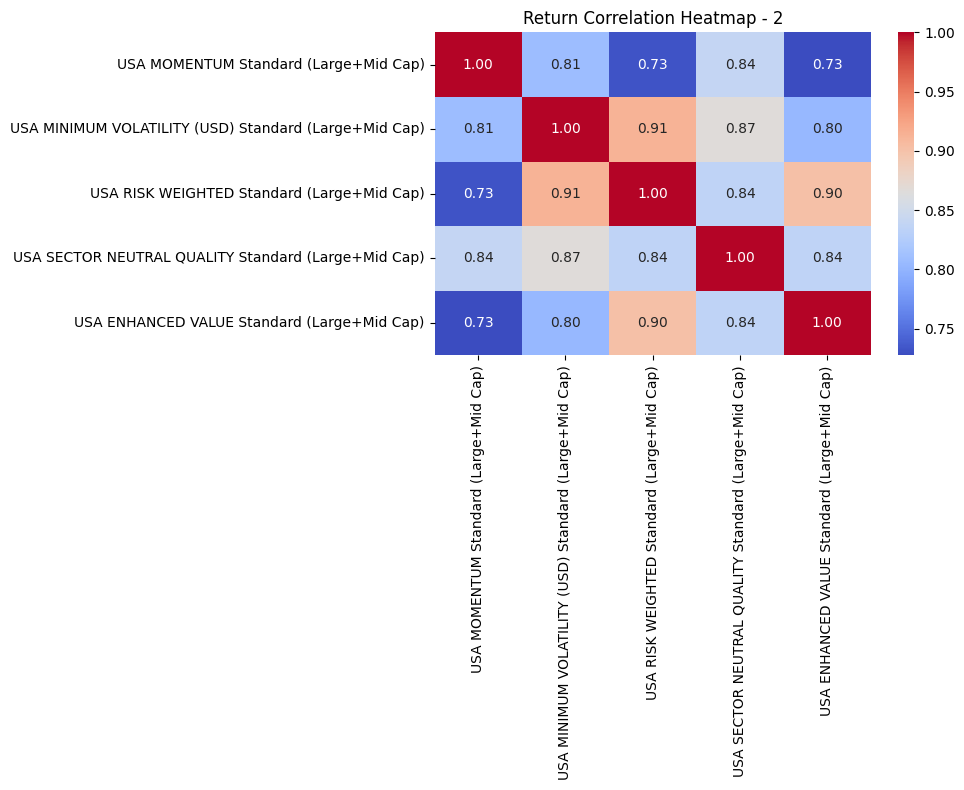

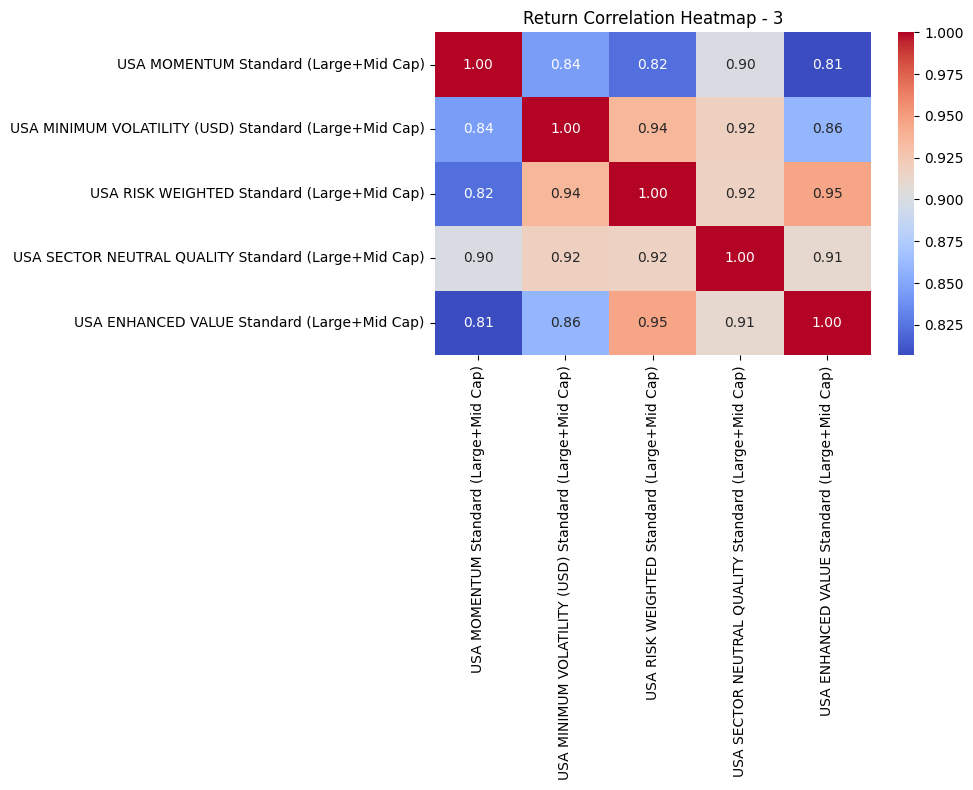

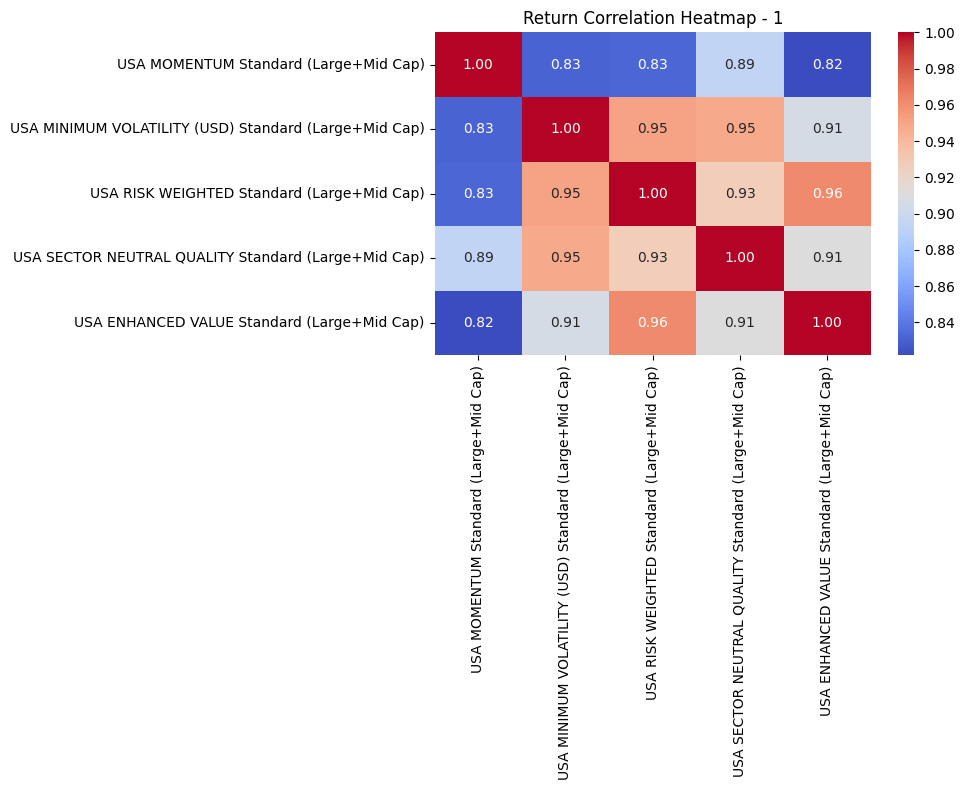

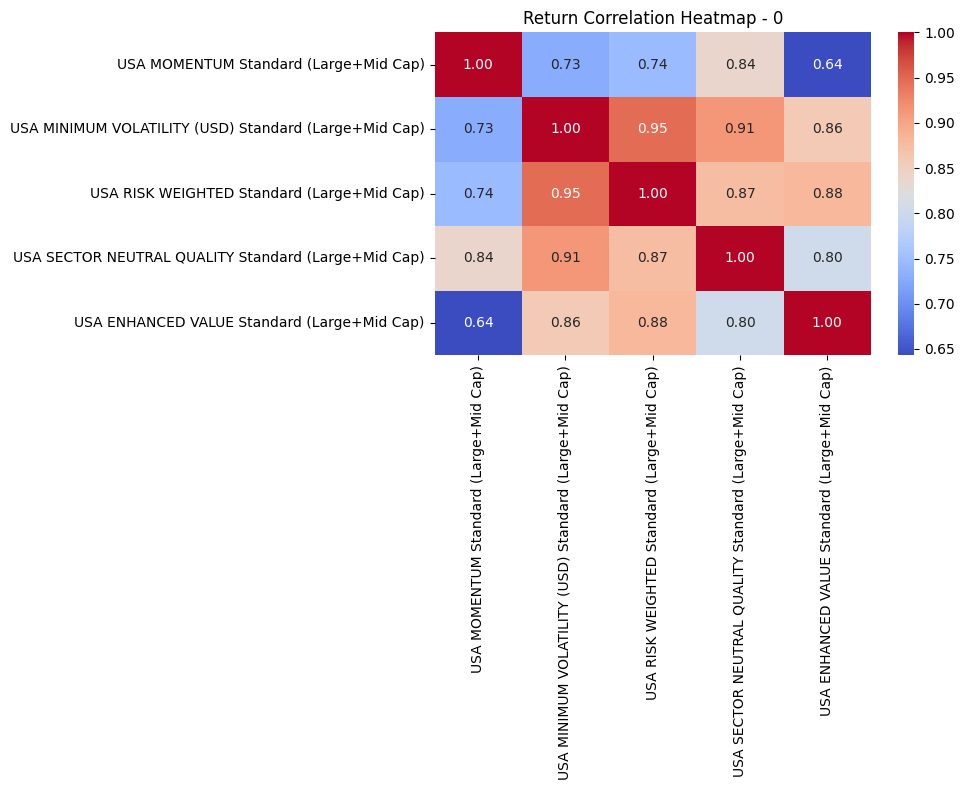

In [50]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global VALID_FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][VALID_FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()


<Figure size 1400x800 with 0 Axes>

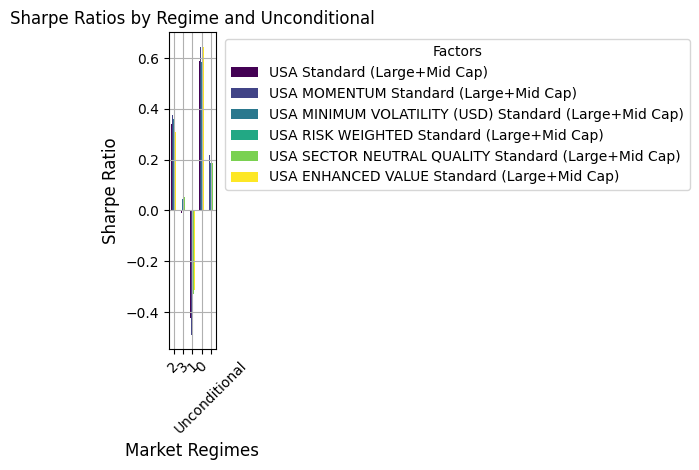

In [51]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.

# %%
# For this analysis, we assume the relevant factors for Sharpe ratios are in columns 1:7.
# (Adjust the slicing as needed.)
factors_columns = df.columns[1:7]
regimes_column = REGIMES_COLUMN

sharpe_ratios = {}
for regime in df[regimes_column].unique():
    regime_data = df[df[regimes_column] == regime][factors_columns]
    mean_returns = regime_data.mean()
    std_devs = regime_data.std()
    sharpe_ratios[regime] = mean_returns / std_devs

# Compute "Unconditional" Sharpe ratios (using all data)
unconditional_mean = df[factors_columns].mean()
unconditional_std = df[factors_columns].std()
sharpe_ratios["Unconditional"] = unconditional_mean / unconditional_std

sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(kind="bar", grid=True, colormap="viridis", title="Sharpe Ratios by Regime and Unconditional")
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
